In [140]:
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import wordnet as wn
from pprint import pprint
import torch.nn.functional as F
import os
import glob
import tqdm 
import torch
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import pytorch_lightning as pl
from model import AutoEncoder, HookedModel, DictionnaryLearner, default_hookedmodel, default_ae
import networkx as nx
from wordnet_data.imagenet_classes_helpers import common_superclass_wnid, ImageNetHierarchy
#%load_ext tensorboard

In [141]:
def load_model(generic_path, wandb_id, epoch = -1):
    path = os.path.join(generic_path, wandb_id, 'checkpoints')
    if epoch == -1:
        ## Create a list of all the epochs with a regex
        epochs = [int(re.findall(r'epoch=(\d+)', x)[0]) for x in os.listdir(path)]
        ## Get the last epoch
        epoch = max(epochs)
    ## Get the ckpt file starting with epoch={epoch}
    ckpt = [x for x in os.listdir(path) if x.startswith(f'epoch={epoch}')][0]
    model = DictionnaryLearner.load_from_checkpoint(os.path.join(path, ckpt))
    return model

In [142]:
!bash dataload_val_only.sh

/tmp/imagenet ~/VisionMonoSemanticity
mkdir: cannot create directory ‘val’: File exists
replace filesystem_info.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
~/VisionMonoSemanticity


In [143]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [251]:
model = load_model('/mnt/home/dheurtel/ceph/02_checkpoints/monosemantic_dictionnary_learning/', '3oyb1afn', -1).to(device)

Lightning automatically upgraded your loaded checkpoint from v1.5.3 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../ceph/02_checkpoints/monosemantic_dictionnary_learning/3oyb1afn/checkpoints/epoch=59-step=75119.ckpt`
/mnt/home/dheurtel/venv/genv_DL/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'layer_to_hook' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['layer_to_hook'])`.


In [252]:
## Get the dictionary of classes for ImageNet

CLASSES_FILE = './classes/imagenet1000_clsidx_to_labels.txt'

with open(CLASSES_FILE) as f:
    idx2classes = eval(f.read())

classes2idx = {v: k for k, v in idx2classes.items()}
simple_classes2idx = {k.split(',')[0]: v for k, v in classes2idx.items()}

In [253]:
valdir = os.path.join('/tmp/imagenet/', 'val')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
def unormalize(batch):
    ## batch of shape (batch_size, 3, 224, 224)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

    return batch * std + mean

val_dataset = datasets.ImageFolder(
    valdir,
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ]))    

In [254]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=8)

In [255]:
len(val_dataset), len(val_loader)

(50000, 98)

In [256]:
feature_acts = torch.zeros(len(val_dataset), model.autoencoder.d_hidden)
all_classes = torch.zeros(len(val_dataset))

progress_bar = tqdm.tqdm(total=len(val_loader), desc='Val', position=0)
for i, (batch, classes) in enumerate(val_loader):
    batch = batch.to(device)
    with torch.no_grad():
        loss, x_reconstruct, acts, l2_loss, l1_loss = model(batch)
    idx_min = i * 512
    idx_max = min((i+1) * 512, len(val_dataset))
    feature_acts[idx_min: idx_max, :] = acts.cpu().detach()
    all_classes[idx_min: idx_max] = classes
    progress_bar.update(1)

Val: 100%|██████████| 98/98 [03:48<00:00,  2.33s/it]


Val: 100%|██████████| 98/98 [00:36<00:00,  4.64it/s]

In [257]:
neuron_acts = torch.zeros(len(val_dataset), model.autoencoder.d_input)
all_classes = torch.zeros(len(val_dataset))

progress_bar = tqdm.tqdm(total=len(val_loader), desc='Val', position=0)
for i, (batch, classes) in enumerate(val_loader):
    batch = batch.to(device)
    with torch.no_grad():
        acts = model.hookedmodel(batch)
    idx_min = i * 512
    idx_max = min((i+1) * 512, len(val_dataset))
    neuron_acts[idx_min: idx_max, :] = acts.cpu().detach()
    all_classes[idx_min: idx_max] = classes
    progress_bar.update(1)

Val: 100%|██████████| 98/98 [00:37<00:00,  2.91it/s]

In [258]:
dead_neurons = (neuron_acts.sum(dim=0) == 0).nonzero().flatten()
dead_features = (feature_acts.sum(dim=0) == 0).nonzero().flatten()

In [259]:
len(dead_features)/model.autoencoder.d_hidden, len(dead_neurons)/model.autoencoder.d_input

(0.9535433070866142, 0.0)

In [260]:
non_dead_neurons = (neuron_acts.sum(dim=0) != 0).nonzero().flatten()
non_dead_features = (feature_acts.sum(dim=0) != 0).nonzero().flatten()

In [262]:
## Sort the classes by neuron_0_acts
feature_to_inspect = 100
feature_to_inspect = non_dead_features[feature_to_inspect]
sorted_classes_idx = torch.argsort(feature_acts[:, feature_to_inspect])
sorted_classes = all_classes[sorted_classes_idx]

In [263]:
feature_acts[:, 229].argmax(), feature_acts[:, 229].max()

(tensor(0), tensor(0.))

In [264]:
sorted_classes_idx[-10:]

tensor([13721, 10058,  8797,  7812, 16734, 13747, 28424,  5408, 16100, 49265])

In [265]:
sorted_classes[-100:]

tensor([201., 259., 154., 370., 204., 155., 277.,  76., 177., 292., 151., 194.,
        568., 157., 261.,   9., 260., 387., 273., 252., 187., 201., 262., 336.,
        299., 252., 368., 336., 226., 197., 377., 334., 289., 375., 269., 378.,
         76., 382., 200., 361., 109., 201., 334., 282., 256., 231., 156., 198.,
        232., 175., 332., 170., 192., 187., 252., 337., 194., 186., 885., 201.,
        193., 244., 359., 387., 191., 337., 373., 201., 278., 231., 201., 202.,
        200., 177., 274., 328., 990., 252., 261., 235., 202., 200., 292., 231.,
        187., 375., 293., 223., 244., 293., 274., 201., 175., 156., 334., 274.,
        568., 108., 322., 985.])

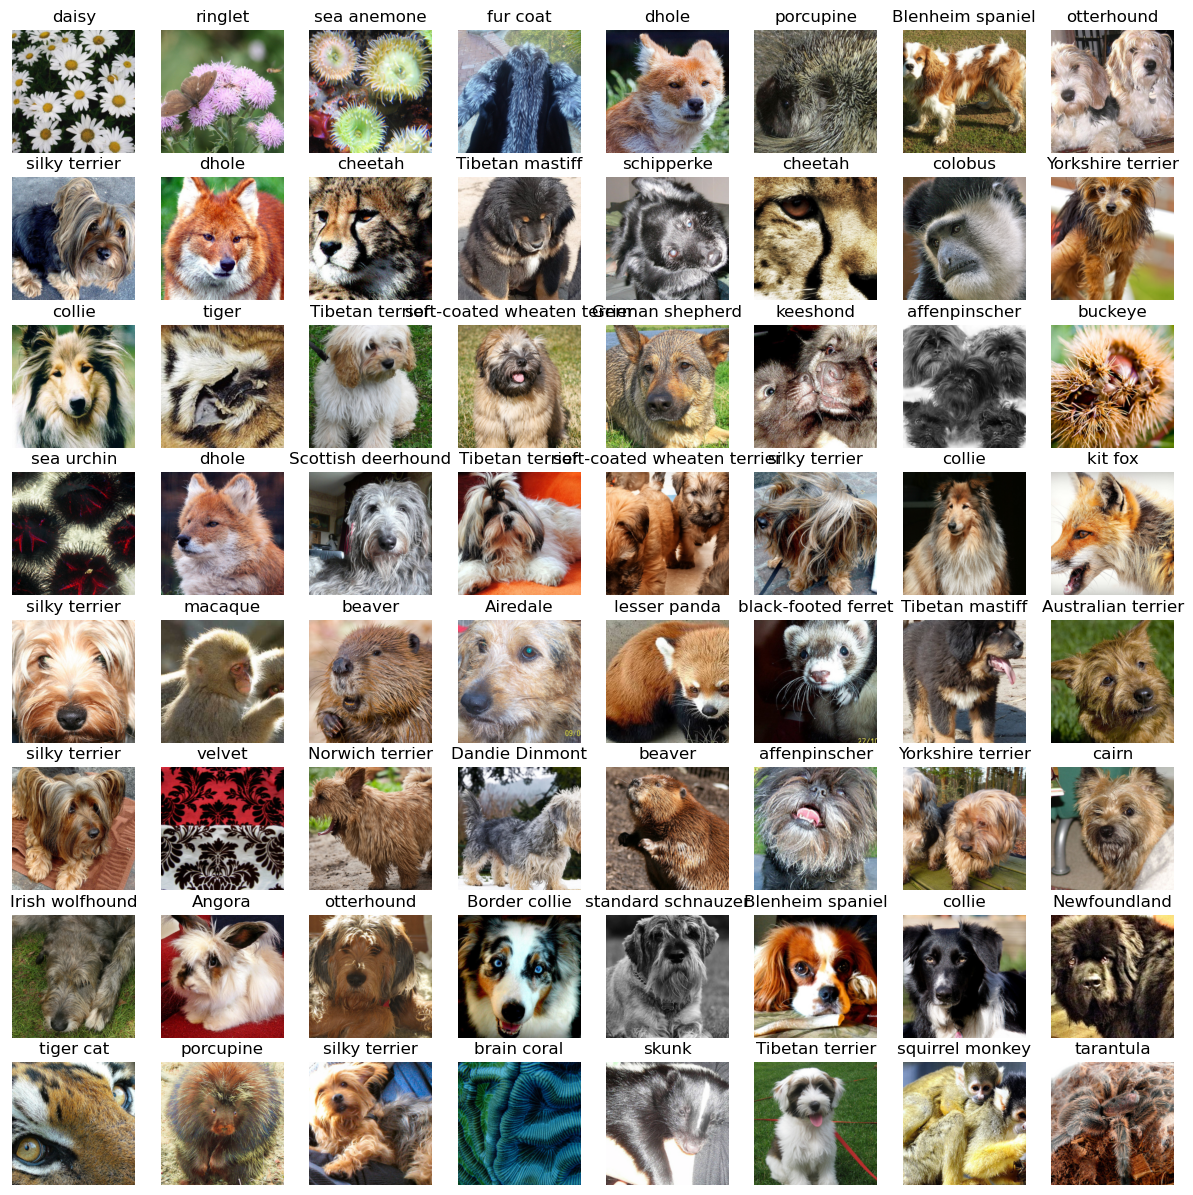

In [266]:
## Plot the 25 images that activate the most the first neuron (use dataset[idx])

import matplotlib.pyplot as plt

fig, axs = plt.subplots(8, 8, figsize=(15,15))

for i in range(8):
    for j in range(8):
        idx = sorted_classes_idx[-(i*8+j+1)]
        img, label = val_dataset[idx]
        img = img.unsqueeze_(0)
        ## Clamp the values between 0 and 1 then 255 int
        img = unormalize(img)[0]
        axs[i, j].imshow(img.permute(1, 2, 0))
        axs[i, j].set_title(idx2classes[label].split(',')[0])
        axs[i, j].axis('off')

plt.show()

In [267]:
os.makedirs('/tmp/imagenet/train', exist_ok=True) ## EMPTY FOLDER
## Make a subfolder for each class, copying the subfolders names in val (for the Imagene hierarchy)
l = os.listdir(valdir)

for c in l:
    os.makedirs(os.path.join('/tmp/imagenet/train', c), exist_ok=True)

In [268]:
in_hier = ImageNetHierarchy('/tmp/imagenet/', './wordnet_data/')

72581


In [269]:
some_dog_classes_file = './utils.txt'

with open(some_dog_classes_file) as f:
    some_dog_classes = f.read().split('\n')

some_dog_classes[:5]

['Chihuahua',
 'Japanese spaniel',
 'Maltese dog, Maltese terrier, Maltese',
 'Pekinese, Pekingese, Peke',
 'Shih-Tzu']

In [270]:
dog_classes_idx = [classes2idx[c] for c in some_dog_classes if c in classes2idx]
dog_classes_idx = torch.tensor(dog_classes_idx)

is_dog = (all_classes.unsqueeze(1) == dog_classes_idx.unsqueeze(0)).any(dim=1)

In [271]:
is_dog.sum()

tensor(5000)

In [272]:
dog_feature_acts = feature_acts[is_dog]

In [273]:
dog_feature_acts.shape

torch.Size([5000, 2540])

In [274]:
## Find the 10 features that are the most activated by dogs.

features_idx = dog_feature_acts.sum(dim=0).argsort()[-10:].flip(dims=(0,))

In [275]:
dog_feature_acts.sum(dim=0)[features_idx]

tensor([17843.1895,  9842.2559,  9774.8428,  9748.6904,  9552.6387,  8337.7852,
         7431.3154,  7211.0352,  6817.4360,  6550.0420])

In [276]:
features_idx

tensor([2273, 1485, 1710, 1081,  212, 2238,    9,  387,  694, 2176])

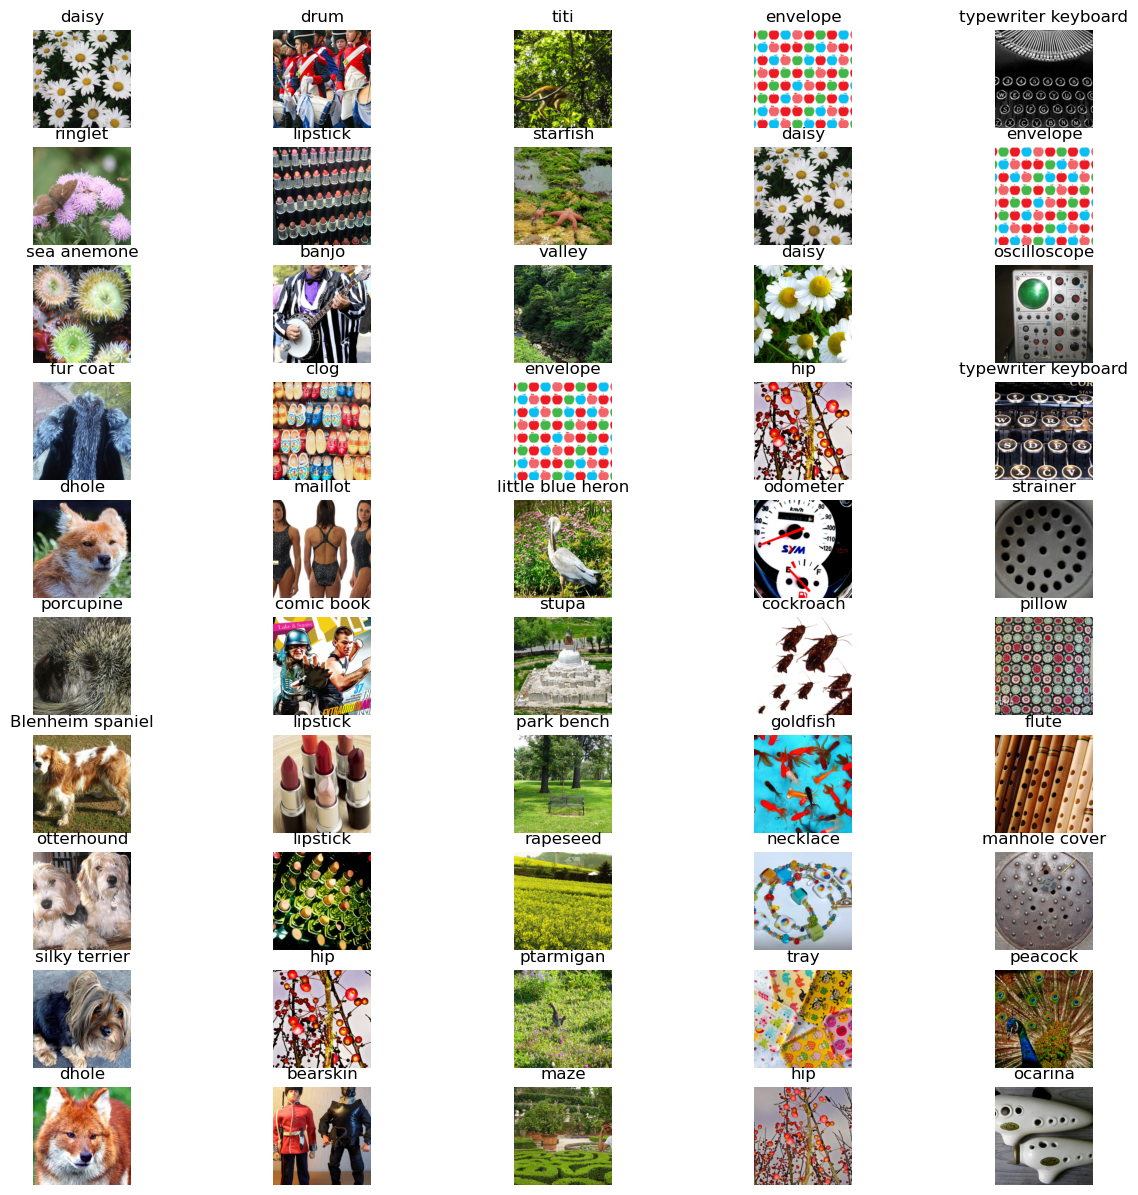

In [277]:
# For the first 5 "dog" features, find the 5 images that activate them the most (no matter whether a dog or not) and plot them (in a column).

fig, axs = plt.subplots(10, 5, figsize=(15,15))

for i in range(5):
    feature = features_idx[i]
    sorted_classes_idx = torch.argsort(feature_acts[:, feature]).flip(dims=(0,))
    for j in range(10):
        idx = sorted_classes_idx[j]
        img, label = val_dataset[idx]
        img = img.unsqueeze_(0)
        ## Clamp the values between 0 and 1 then 255 int
        img = unormalize(img)[0]
        axs[j, i].imshow(img.permute(1, 2, 0))
        axs[j, i].set_title(idx2classes[label].split(',')[0])
        axs[j, i].axis('off')